# BIGRAM Language Modelling
Here, I'll implement a simple bigram model to predict the next character in a sequence.

In [2]:
# Load the dataset
with open('names.txt', 'r') as f:
    names = f.read().splitlines()

print(f"Count: {len(names)}, sample: {names[:5]}...")

Count: 32033, sample: ['emma', 'olivia', 'ava', 'isabella', 'sophia']...


## Creating a bigram model

To create a very basic bi-gram model, we'll split our dataset into pairs of 2.

We'll have to encode 'beginning' and 'end' special chars (e.g. '>' and '.').

Then, we want to count the frequencies of these chars from our dataset (i.e. we need a 2D matrix -> given the first character, what's the likely next char).

We'll want to also normalize the dataset per row (this gives us a nice 0-1 value which we can use for sampling the next char using a probability distribution (which type of distribution? Uniform random distribution?))

Count: 32033, sample: ['>emma.', '>olivia.', '>ava.', '>isabella.', '>sophia.']...


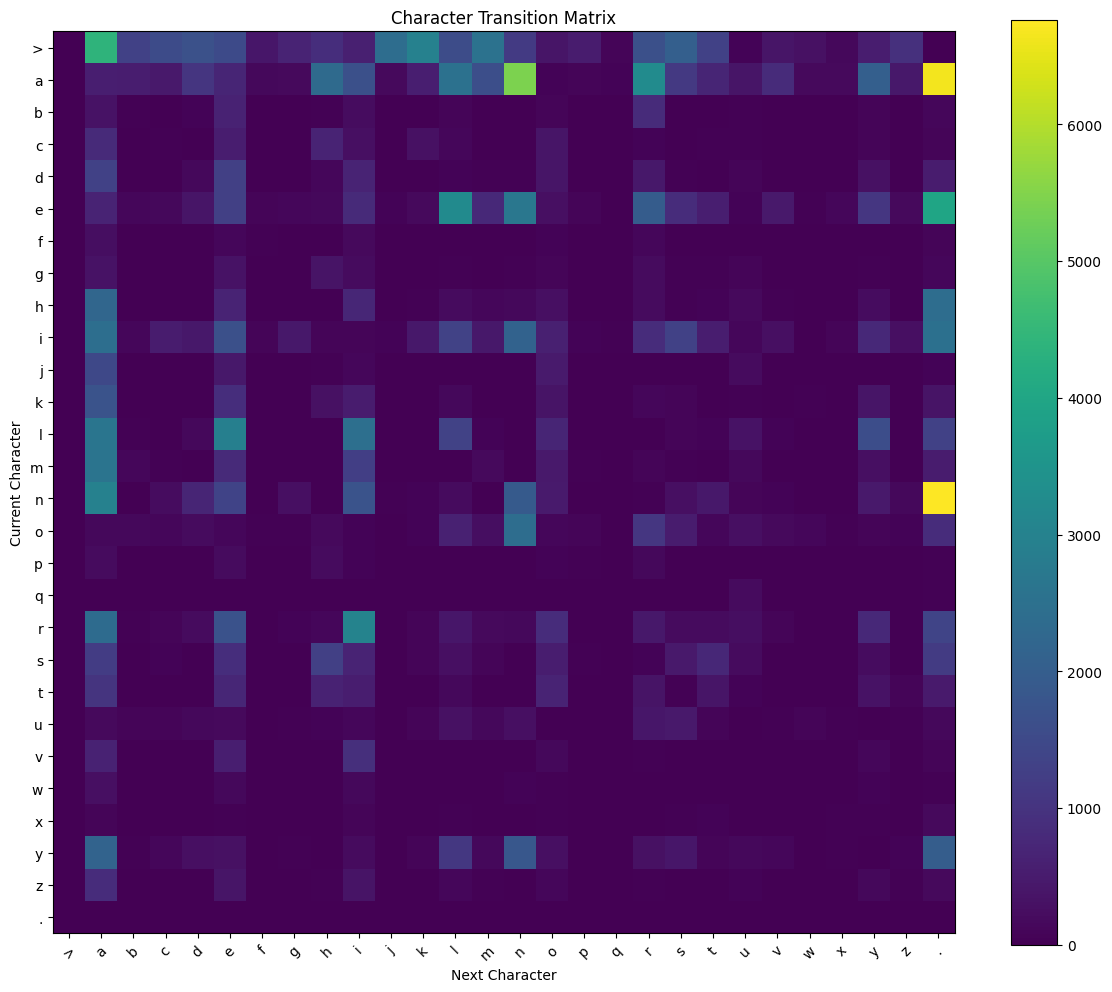

In [3]:
formatted_names = []

# Preprend + append the start/end tokens
START_TOKEN = ">"
END_TOKEN = "."

for name in names:
    formatted = START_TOKEN + name + END_TOKEN
    formatted_names.append(formatted)

print(f"Count: {len(formatted_names)}, sample: {formatted_names[:5]}...")

# Create a 2-char sliding window and count the frequencies
VOCAB_SIZE = 28
matrix = []

for i in range(VOCAB_SIZE):
    matrix.append([0]*VOCAB_SIZE)

for formatted_name in formatted_names:
    for i, char in enumerate(formatted_name):
        if i == 0:
            continue
        
        first = formatted_name[i-1]
        second = formatted_name[i]

        first_i = ord(first)-ord('a')+1
        second_i = ord(second)-ord('a')+1
        
        if first == START_TOKEN:
            first_i = 0

        if second == END_TOKEN:
            second_i = 27

        matrix[first_i][second_i] += 1

#Print the matrix
import matplotlib.pyplot as plt
import numpy as np

def visualize_matrix(matrix_param):
    # Create labels for rows and columns
    labels = ['>'] + [chr(i+96) for i in range(1,27)] + ['.']

    plt.figure(figsize=(12,10))
    plt.imshow(matrix_param, cmap='viridis')
    plt.colorbar()

    # Set the ticks and labels
    plt.xticks(range(VOCAB_SIZE), labels, rotation=45)
    plt.yticks(range(VOCAB_SIZE), labels)

    plt.xlabel('Next Character')
    plt.ylabel('Current Character')
    plt.title('Character Transition Matrix')

    plt.tight_layout()
    plt.show()

visualize_matrix(matrix)

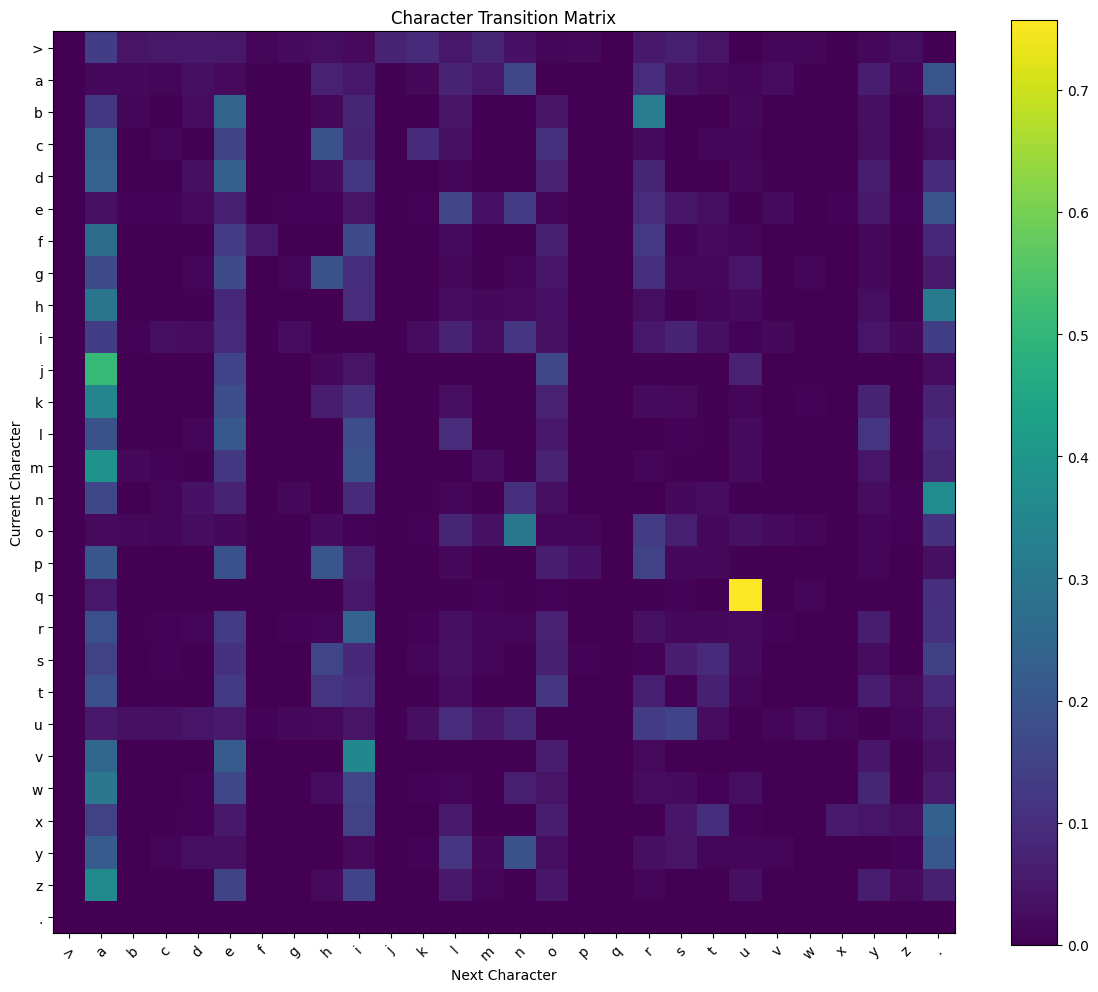

In [4]:
# Normalize each row
for i, row in enumerate(matrix):
    rowsum = sum(row)

    if rowsum != 0:
        for j, col in enumerate(row):
            matrix[i][j] = float(col)/float(rowsum)

visualize_matrix(matrix)

In [5]:
# Using the normalized matrix, we can now start to sample the dataset to predict the next token.
# Using the normalized matrix, we can now start to sample the dataset to predict the next token.
generated = ""
current_index = 0  # Start with '>' token (index 0)
latest_char = START_TOKEN

while latest_char != END_TOKEN:
    # Sample the next index based on the probability distribution in matrix[current_index]
    next_index = np.random.choice(VOCAB_SIZE, p=matrix[current_index])
    
    # Convert index back to character
    if next_index == 0:
        latest_char = START_TOKEN
    elif next_index == 27:
        latest_char = END_TOKEN
    else:
        latest_char = chr(next_index + ord('a') - 1)
    
    if latest_char != END_TOKEN:  # Don't append the end token
        generated += latest_char
    
    current_index = next_index

print(f"Generated name: {generated}")

Generated name: ka


## Using a neural network

Now, let's try to model this 'next-char' prediction with a neural network instead.

To model this, let's answer the following questions:
1. What would be the input? 
2. What would be the output? 
3. What would be the loss function?

1. Input: We want the input to be the last char of our current string.
2. Output: We want to output to be a logit vector (representing probabilities of the next most likely char).
3. Loss: We'd want our model to minimize the loss so that it's closer to the original distribution (i.e. something like multiply the probs of the next char and take the total 'entropy' of this).

Expanding on the loss function:
Our output would look as such: 

training_sample [a,b] => model_input: a, model_output: [a:0.01, b:0.03, c:0.3] -> We'd want our model to increase the 'b' probability

By convention, we want our loss to be a positive number and go down to 0 as we optimize. Thus we must transform the probability.

A good option here would be to take the log.

log(0....) -> intends to -infinity
log(1...) -> intends to 0

The higher the probability, the lower the loss. We want this to be the case for positive examples

So we can take our loss as the negative log likelihood:

Loss = -log(chars) = -(log(c1*c2*c3*c4)) = -(logc1 + logc2 + logc3 + logc4)

When we give a training example as above -> We e.g. infer [a] and pull out the col of [b]. We then calculate the loss as the neg log likelihood. We then backprop this which will in turn increase the prob of b. Since we're noramlizing in the softmax step, this means prob b will be higher but the overall prob will still be 1.

In [6]:
#Test the data is loaded
names[:3]

['emma', 'olivia', 'ava']

In [9]:
# Generate and split the dataset
#TODO: We probably want these to be torch tensors with no grad right?

X = []
Y = []
for name in names:
    processed = "." + name + "."
    for i, c in enumerate(processed):
        if i == 0:
            continue
        X.append(processed[i-1])
        Y.append(processed[i])

n = len(X)
X_train = X[:n*0.8]
Y_train = Y[:n*0.8]
X_val = X[n*0.8:n*0.9]
Y_val = Y[n*0.8:n*0.9]
X_test = X[n*0.9:]
Y_test = Y[n*0.9:]

print(X_train, Y_train)

['.', 'e', 'm', 'm', 'a', '.', 'o', 'l', 'i', 'v', 'i', 'a', '.', 'a', 'v', 'a', '.', 'i', 's', 'a', 'b', 'e', 'l', 'l', 'a', '.', 's', 'o', 'p', 'h', 'i', 'a', '.', 'c', 'h', 'a', 'r', 'l', 'o', 't', 't', 'e', '.', 'm', 'i', 'a', '.', 'a', 'm', 'e', 'l', 'i', 'a', '.', 'h', 'a', 'r', 'p', 'e', 'r', '.', 'e', 'v', 'e', 'l', 'y', 'n', '.', 'a', 'b', 'i', 'g', 'a', 'i', 'l', '.', 'e', 'm', 'i', 'l', 'y', '.', 'e', 'l', 'i', 'z', 'a', 'b', 'e', 't', 'h', '.', 'm', 'i', 'l', 'a', '.', 'e', 'l', 'l', 'a', '.', 'a', 'v', 'e', 'r', 'y', '.', 's', 'o', 'f', 'i', 'a', '.', 'c', 'a', 'm', 'i', 'l', 'a', '.', 'a', 'r', 'i', 'a', '.', 's', 'c', 'a', 'r', 'l', 'e', 't', 't', '.', 'v', 'i', 'c', 't', 'o', 'r', 'i', 'a', '.', 'm', 'a', 'd', 'i', 's', 'o', 'n', '.', 'l', 'u', 'n', 'a', '.', 'g', 'r', 'a', 'c', 'e', '.', 'c', 'h', 'l', 'o', 'e', '.', 'p', 'e', 'n', 'e', 'l', 'o', 'p', 'e', '.', 'l', 'a', 'y', 'l', 'a', '.', 'r', 'i', 'l', 'e', 'y', '.', 'z', 'o', 'e', 'y', '.', 'n', 'o', 'r', 'a', '.',

TypeError: slice indices must be integers or None or have an __index__ method